# Elementary Air Conditioning Processes (Part 1)
---

In [1]:
from deps import load_packages

load_packages()

In [2]:
import jupyter_addons as ja
ja.set_css()

This chapter shows how basic air conditioning processes can be handled with the `hvac` package by going through some textbook problems.

Air conditioning processes in package `hvac`are modeled by the class `AirConditioningProcess`. To use this class in a module, script or Jupyter notebook the following classes also need to be imported from the `hvac` package:

In [3]:
from hvac import Quantity
from hvac.fluids import HumidAir, Fluid
from hvac.charts import PsychrometricChart, StatePoint
from hvac.air_conditioning import AirConditioningProcess

Class `Quantity`, which comes from the third-party package [**Pint**](https://pint.readthedocs.io/en/stable/), represents a physical quantity. Air conditioning is all about the conditioning of humid air. Humid air is represented by the class `HumidAir`. Humid air, but also processes like air humidification and dehumidification, imply the presence of water. Water is a fluid and therefore we will use the class `Fluid`, which is actually an interface to the third-party package [**CoolProp**](http://www.coolprop.org/), to create a `Water` object. The classes `PsychrometricChart` and `StatePoint` are used to draw airconditioning processes on a psychrometric chart.

In [4]:
Water = Fluid('Water')

We also define an alias as a shortcut for creating `Quantity` instances:

In [5]:
Q_ = Quantity

## 1. Air Heating Coil: Sensible Heating

*A heating coil heats 1.5 m<sup>3</sup>/s of moist air, initially at a state of 21 °C dry-bulb, 15 °C wet-bulb and 101.325 kPa barometric pressure, by 20 degrees. Calculate the load on the heating coil.*

**Air state at entrance of heating coil**
- dry-bulb temperature = 21 °C
- wet-bulb temperature = 15 °C

In [6]:
air_in = HumidAir(Tdb=Q_(21, 'degC'), Twb=Q_(15, 'degC'))

**Air state at exit of heating coil**
- dry-bulb temperature = 41 °C
- moisture content remains constant in sensible heating process

In [7]:
air_out = HumidAir(Tdb=Q_(41, 'degC'), W=air_in.W)

**Air mass flow rate through heating coil**
- air volume flow rate at entrance of battery = 1.5 m³/s
- dry-air density of inlet air is known from the inlet condition of air

In [8]:
V_a = Q_(1.5, 'm ** 3 / s')
m_da = air_in.rho * V_a

**Heating coil load**

Knowing the state of the inlet and outlet air and also the mass flow rate of air through the heating coil, the sensible heating process is fully determined. We can now create an instance of the `AirConditioningProcess` class, passing the known process parameters.

In [9]:
heating_coil = AirConditioningProcess(
    air_in=air_in,
    air_out=air_out,
    m_da=m_da,
)

The heating load on the `heating_coil` object is accessed through property `Q` which returns a `Quantity` object. 

In [10]:
ja.display_list([f"heating coil load = <b>{heating_coil.Q.to('kW'):~P.3f}</b>"])

The sensible heating process can be drawn on a psychrometric chart. The code below shows how to this. First, an instance of the `PsychrometricChart` class is created. Then its method `plot_process` can be called. You must give a name to the process and specify its start and end point. A point on the psychrometric chart, of which the coordinates are dry-bulb temperature `Tdb` and absolute humidity ratio `W`, is represented by an instance of class `StatePoint`. To display the chart on screen, call method `show` on the psychrometric chart instance.

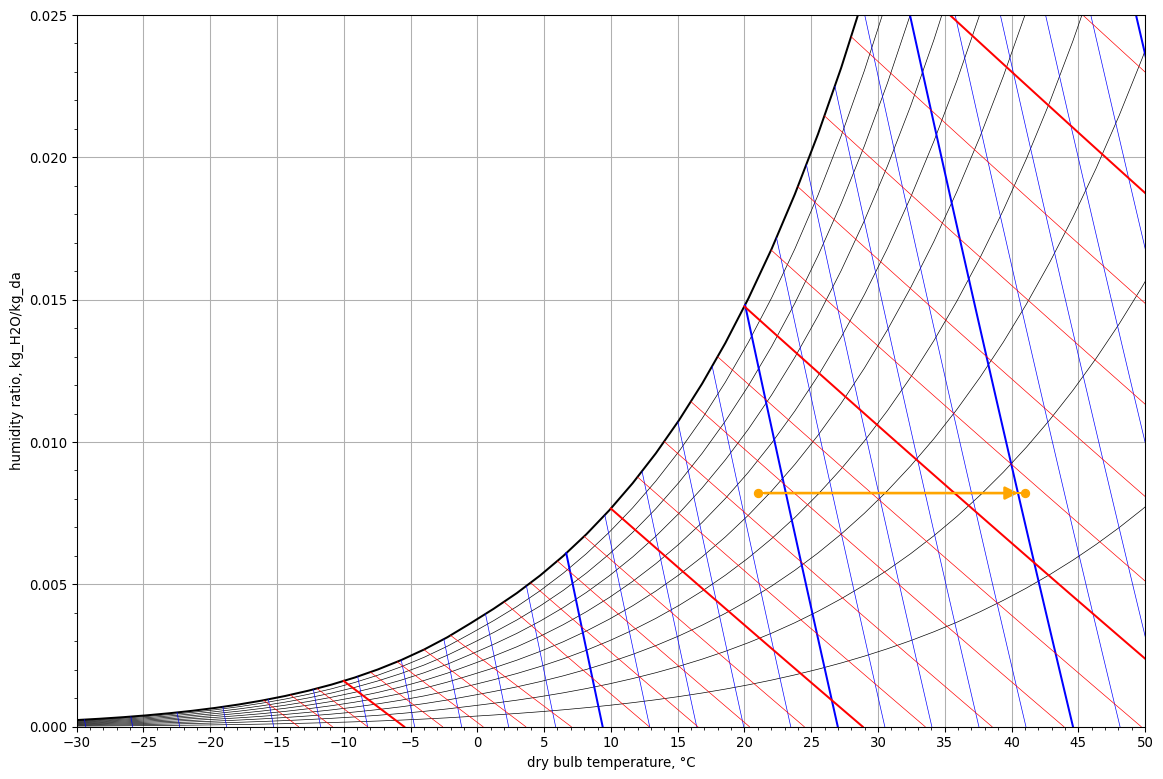

In [11]:
psych_chart = PsychrometricChart()
psych_chart.plot_process(
    name='sensible heating',
    start_point=StatePoint(air_in.Tdb, air_in.W),
    end_point=StatePoint(air_out.Tdb, air_out.W)
)
psych_chart.show()

## 2. Air Cooling Coil: Cooling and Dehumidification

*1.5 m<sup>3</sup>/s of moist air at a state of 28 °C dry-bulb, 20.6 °C wet-bulb and 101.325 kPa flows across a cooler coil and leaves the coil at 12.5 °C dry-bulb and 8.336 g per kg of dry air. Calculate the apparatus dew point, the contact factor and the cooling load.*

**Air state at cooling coil entrance**
- dry-bulb temperature = 28.0 °C
- wet-bulb temperature = 20.6 °C

In [12]:
air_in = HumidAir(Tdb=Q_(28.0, 'degC'), Twb=Q_(20.6, 'degC'))

**Air state at cooling coil exit**
- dry-bulb temperature = 12.5 °C
- humidity ratio = 8.336 g/kg

In [13]:
air_out = HumidAir(Tdb=Q_(12.5, 'degC'), W=Q_(8.336, 'g / kg'))

**Mass flow rate of dry air through cooling coil**
- air volume flow rate at entrance of battery = 1.5 m³/s
- dry-air density of inlet air is known from the inlet air state

In [14]:
V = Q_(1.5, 'm ** 3 / s')
m_da = air_in.rho * V

**Cooling coil load**

We will ignore the energy from the condensate. This is done by setting the parameters `m_w` (i.e. the mass flow rate of water condensate) and `h_w` (i.e. the enthalpy of the condensate) to zero.

In [15]:
air_cooler = AirConditioningProcess(
    air_in=air_in,
    air_out=air_out,
    m_da=m_da,
    m_w=Q_(0.0, 'kg / s'),
    h_w=Q_(0.0, 'J / kg')
)

ja.display_list([f"cooling load = <b>{air_cooler.Q.to('kW'):~P.3f}</b>"])

**Apparatus dew point (ADP) temperature**

The apparatus dew point (ADP) is the point on the psychrometric diagram where the cooling process line intersects the saturation line of humid air. As such, the relative humidity at the ADP is always 100 %. To determine the state of the ADP it therfore suffices to find its dry-bulb temperature. After the air cooling process has been defined and is fully determined, we can access the ADP through property `ADP` of the `AirConditioningProcess` instance representing the air cooling process:

In [16]:
ADP = air_cooler.ADP

ja.display_list([f"ADP temperature = <b>{ADP.Tdb.to('degC'):~P.1f}</b>"])

**Contact factor**

The cooling process in a real air cooling coil could be considered as an adiabatic mixing process of an air stream flowing through a "perfect" air cooling coil which is cooled to ADP and an air stream that bypasses the "perfect" air cooler, thus remaining at the inlet air state.
The contact factor, designated by `beta`  is the fraction of air that goes through the "perfect" air cooling coil.

In [17]:
beta = air_cooler.beta

ja.display_list([f"contact factor = <b>{beta.to('frac'):~P.2f}</b>"])

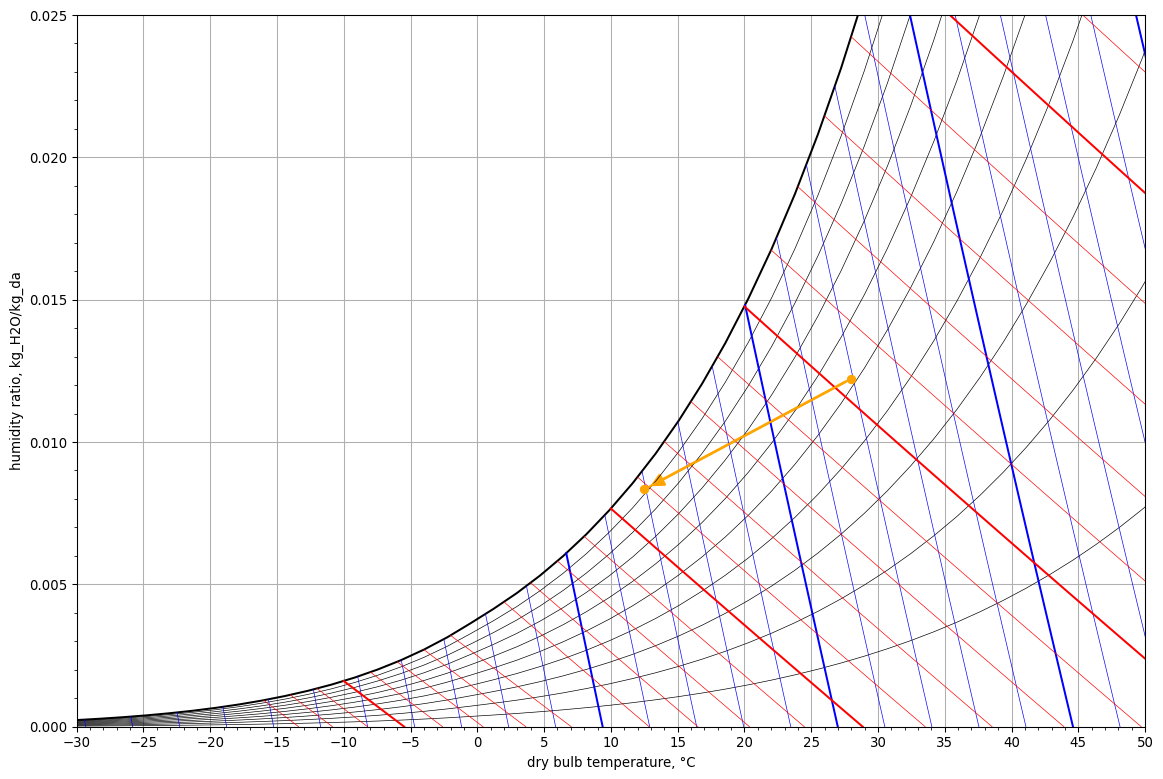

In [18]:
psych_chart = PsychrometricChart()
psych_chart.plot_process(
    name='air cooling',
    start_point=StatePoint(air_in.Tdb, air_in.W),
    end_point=StatePoint(air_out.Tdb, air_out.W)
)
psych_chart.show()

## 3. Evaporative Cooler: Cooling and Humidification 

*1.5 m<sup>3</sup>/s of moist air at a state of 15 °C dry-bulb, 10 °C wet-bulb, and 101.325 kPa barometric pressure, enters the spray chamber of an air washer. The humidifying efficiency of the washer is 90 %, all the spray water is recirculated, the spray chamber and the tank are perfectly lagged, and mains water at 10 °C is supplied to make good the losses due to evaporation. Calculate the state of the air leaving the washer.*

>_**NOTE**<br>
The humidifying efficiency or effectiveness has the same definition as the contact factor in case of an air cooler. To specify the efficiency when instantiating the `AirConditioningProcess`, use parameter `beta`._

**Air state at air washer inlet**
- dry-bulb temperature = 15 °C
- wet-bulb temperature = 10 °C

In [19]:
air_in = HumidAir(Tdb=Q_(15.0, 'degC'), Twb=Q_(10.0, 'degC'))

**Mass flow rate of dry air**
- Volume flow rate of inlet air = 1.5 m<sup>3</sup>/s
- Density of inlet air is known from given state of inlet air

In [20]:
V_moist = Q_(1.5, 'm ** 3 / s')
m_da = air_in.rho * V_moist

**Air state at air washer outlet**

Besides the inlet air state, the air washer efficiency, and the mass flow rate of dry air, we also know from the problem statement that no heat transfer is taking place in the air washer between the air stream and the environment (i.e. adiabatic process). Consequently, `Q` can be set to zero.

In [21]:
air_washer = AirConditioningProcess(
    air_in=air_in,
    beta=Q_(90.0, 'pct'),
    ADP=HumidAir(Tdb=air_in.Twb, RH=Q_(100.0, 'pct')),
    m_da=m_da,
    Q=Q_(0.0, 'W')
)

ja.display_list([
    f"dry-bulb temperature = <b>{air_washer.air_out.Tdb.to('degC'):~P.1f}</b>",
    f"humidity ratio = <b>{air_washer.air_out.W.to('g/kg'):~P.0f}</b>"
])

**Mass flow rate of make-up water**

In [22]:
ja.display_list([
    f"mass flow rate of make-up water = <b>{air_washer.m_w.to('kg/hr'):~P.3f}</b>"
])

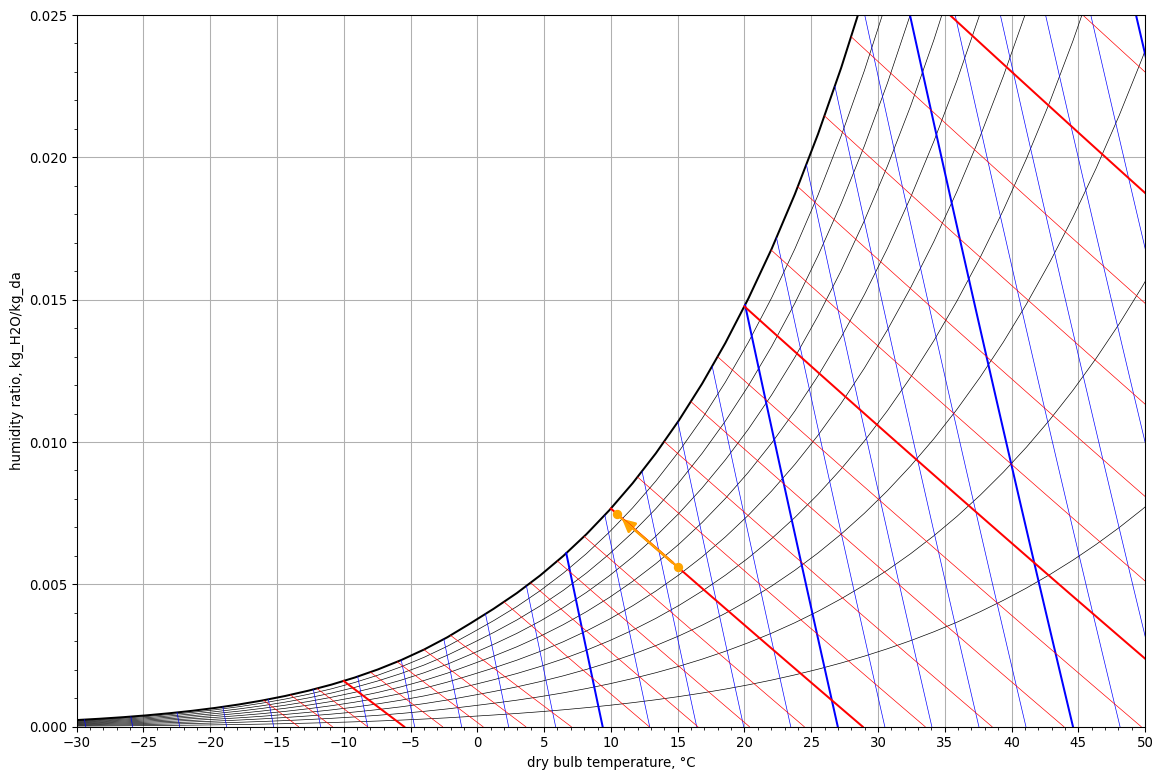

In [23]:
psych_chart = PsychrometricChart()
psych_chart.plot_process(
    name='evaporative cooling',
    start_point=StatePoint(air_washer.air_in.Tdb, air_washer.air_in.W),
    end_point=StatePoint(air_washer.air_out.Tdb, air_washer.air_out.W)
)
psych_chart.show()

## 4. Spray Chamber: Cooling and Humidification by Water Injection

*Moist air at a state of 21 °C dry-bulb, 15 °C wet-bulb, and 101.325 kPa barometric pressure enters a spray chamber. For each kilogram of dry air passing through the chamber, 0.002 kg of water at 100 °C is injected and totally evaporated. Calculate moisture content, enthalpy and dry-bulb temperature of the moist air leaving the chamber.*

**Air state at spray chamber entrance**

- dry-bulb temperature = 21 °C
- wet-bulb temperature = 15 °C

In [24]:
air_in = HumidAir(Tdb=Q_(21.0, 'degC'), Twb=Q_(15.0, 'degC'))

**Mass flow rate of dry air**

- mass flow rate of dry air = 1.0 kg/s 

In [25]:
m_da = Q_(1.0, 'kg / s')

**Mass flow rate of water**
- mass flow rate of water = 0.002 kg/s

In [26]:
m_w = Q_(0.002, 'kg / s')

**Injected water state**

- water temperature = 100 °C
- liquid water at 100 °C and atmospheric pressure is saturated; so the steam quality is 0%.

In [27]:
water = Water(T=Q_(100.0, 'degC'), x=Q_(0.0, 'pct'))

**Air state at spray chamber exit**

In a spray chamber only water is injected to the air stream. No heat is transferred to or extracted from the air stream; so `Q` is zero.

In [28]:
spray_chamber = AirConditioningProcess(
    air_in=air_in,
    m_da=m_da,
    m_w=m_w,
    h_w=water.h,
    Q=Q_(0.0, 'W')
)

air_out = spray_chamber.air_out

ja.display_list([
    f"outlet air moisture content = <b>{spray_chamber.air_out.W.to('g/kg'):~P.3f}</b>",
    f"outlet air enthalpy = <b>{spray_chamber.air_out.h.to('kJ/kg'):~P.0f}</b>",
    f"outlet air dry-bulb temperature = <b>{spray_chamber.air_out.Tdb.to('degC'):~P.1f}</b>"
])

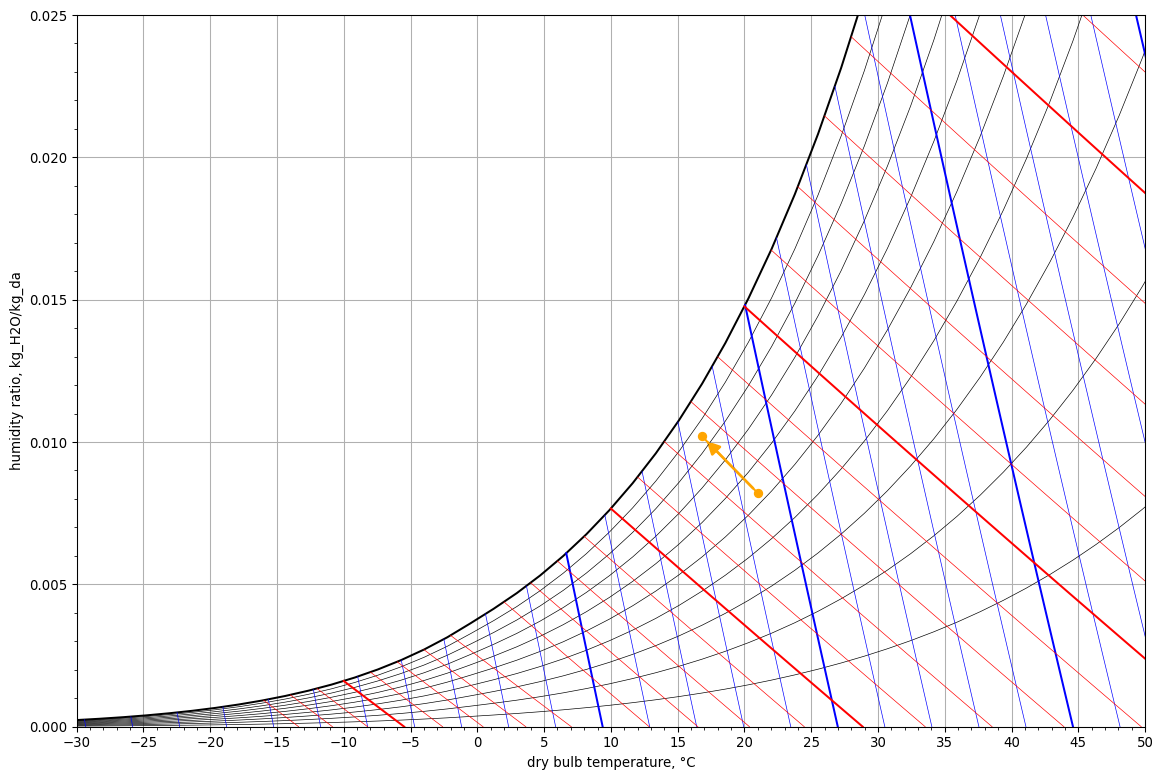

In [29]:
psych_chart = PsychrometricChart()
psych_chart.plot_process(
    name='water injection',
    start_point=StatePoint(air_in.Tdb, air_in.W),
    end_point=StatePoint(air_out.Tdb, air_out.W)
)
psych_chart.show()

## 5. Humidification by Steam Injection (Part 1: saturated steam at 100 °C)

*Dry saturated steam at 100 °C is injected at a rate of 0.01 kg/s into a moist airstream moving at a rate of 1 kg of dry air per second and initially at a state of 28 °C dry-bulb, 11.9 °C wet-bulb and 101.325 kPa barometric pressure. Calculate the leaving state of the moist airstream.*

**Air state at inlet**
- dry-bulb temperature = 28 °C
- wet-bulb temperature = 11.9 °C

In [30]:
air_in = HumidAir(Tdb=Q_(28.0, 'degC'), Twb=Q_(11.9, 'degC'))

**Mass flow rate of dry air**

In [31]:
m_da = Q_(1.0, 'kg / s')

**State of injected steam**
- dry-bulb temperature = 100 °C
- saturated

In [32]:
steam = Water(T=Q_(100.0, 'degC'), x=Q_(100, 'pct'))

ja.display_list([
    f"steam pressure (abs) = <b>{steam.P.to('bar'):~P.3f}</b>",
    f"steam enthalpy = <b>{steam.h.to('kJ / kg'):~P.3f}</b>"
])

**Mass flow rate of steam**

In [33]:
m_w = Q_(0.01, 'kg / s')

**Air state at outlet**

In [34]:
steam_injection = AirConditioningProcess(
    air_in=air_in,
    m_da=m_da, 
    Q=Q_(0.0, 'W'),
    h_w=steam.h,
    m_w=m_w
)

air_out = steam_injection.air_out

ja.display_list([
    f"outlet air moisture content = <b>{air_out.W.to('g/kg'):~P.3f}</b>",
    f"outlet air enthalpy = <b>{air_out.h.to('kJ/kg'):~P.3f}</b>",
    f"outlet air dry-bulb temperature = <b>{air_out.Tdb.to('degC'):~P.1f}</b>"
])

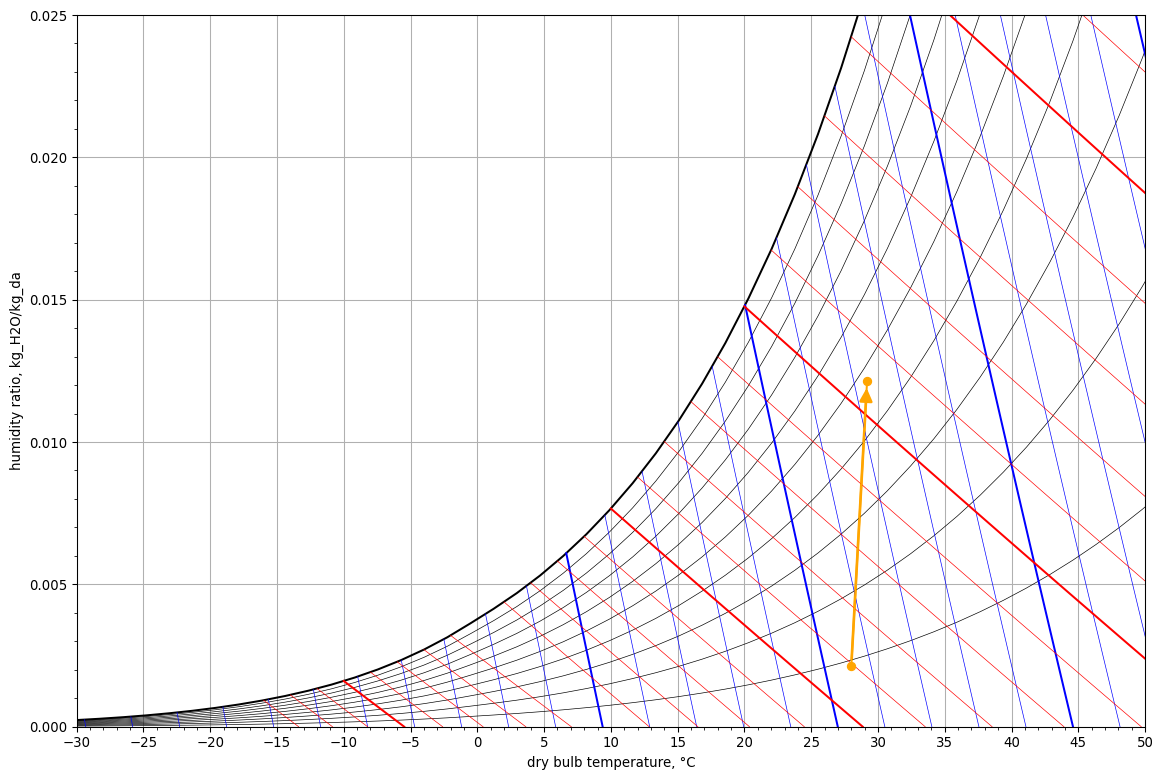

In [35]:
psych_chart = PsychrometricChart()
psych_chart.plot_process(
    name='steam injection',
    start_point=StatePoint(air_in.Tdb, air_in.W),
    end_point=StatePoint(air_out.Tdb, air_out.W)
)
psych_chart.show()

## 6. Humidification by Steam Injection (Part 2: saturated steam at 30 bar)

*Dry saturated steam at 30 bar is injected at a rate of 0.01 kg/s into a moist airstream moving at a rate of 1 kg of dry air per second and initially at a state of 28 °C dry-bulb, 11.9 °C wet-bulb and 101.325 kPa barometric pressure. Calculate the leaving state of the moist airstream.*

**Air state at inlet**
- dry-bulb temperature = 28 °C
- wet-bulb temperature = 11.9 °C

In [36]:
air_in = HumidAir(Tdb=Q_(28.0, 'degC'), Twb=Q_(11.9, 'degC'))

ja.display_list([f"RH of inlet air = <b>{air_in.RH.to('pct'):~P.0f}</b>"])

**Mass flow rate of dry air**

In [34]:
m_da = Q_(1.0, 'kg / s')

**State of injected steam**
- steam pressure = 30 bar
- saturated

In [37]:
steam = Water(P=Q_(30.0, 'bar'), x=Q_(100, 'pct'))

ja.display_list([
    f"steam temperature = <b>{steam.T.to('degC'):~P.1f}</b>",
    f"steam enthalpy = <b>{steam.h.to('kJ / kg'):~P.3f}</b>"
])

**Mass flow rate of steam**

In [38]:
m_w = Q_(0.01, 'kg / s')

**Air state at outlet**

In [39]:
steam_injection = AirConditioningProcess(
    air_in=air_in,
    m_da=m_da,
    Q=Q_(0.0, 'W'),
    h_w=steam.h,
    m_w=m_w
)

air_out = steam_injection.air_out

ja.display_list([
    f"outlet air moisture content = <b>{air_out.W.to('g/kg'):~P.3f}</b>",
    f"outlet air enthalpy = <b>{air_out.h.to('kJ/kg'):~P.3f}</b>",
    f"outlet air dry-bulb temperature = <b>{air_out.Tdb.to('degC'):~P.1f}</b>"
])

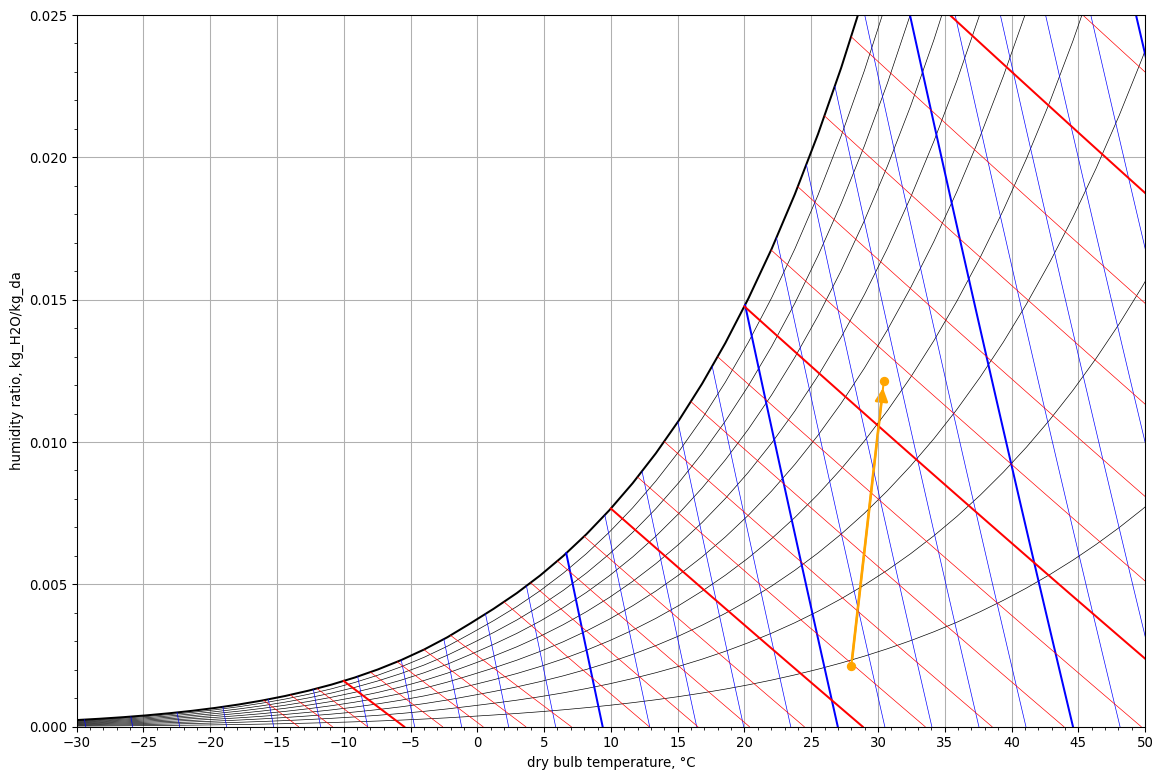

In [40]:
psych_chart = PsychrometricChart()
psych_chart.plot_process(
    name='steam injection',
    start_point=StatePoint(air_in.Tdb, air_in.W),
    end_point=StatePoint(air_out.Tdb, air_out.W)
)
psych_chart.show()

## 7. Cooling and Dehumidification with Reheat

### Design Load Conditions

*Moist air flows over a cooler coil and leaves it at a state of 10 °C dry-bulb and 7.046 g per kg of dry air. Room dry-bulb temperature is 21 °C. The supply air is required to offset a sensible heat gain of 2.35 kW and a latent heat gain of 0.31 kW. Calculate the mass of dry air which must be supplied to the room and what will be the relative humidity in the room?*

**Sensible and latent heat load of the room**

- sensible heat load = 2.35 kW
- latent heat load = 0.31 kW

In [41]:
Q_sen = Q_(2.35, 'kW')
Q_lat = Q_(0.31, 'kW')

**State of room supply air**

- dry-bulb temperature = 10 °C
- moisture content = 7.046 g/kg

In [44]:
room_air_in = HumidAir(Tdb=Q_(10.0, 'degC'), W=Q_(7.046, 'g / kg'))

**Required mass flow rate of dry air and relative humidity in the room**

In [45]:
room_design = AirConditioningProcess(
    air_in=room_air_in,
    Q_sen=Q_sen,
    Q_lat=Q_lat,
    h_w=Q_(0.0, 'J / kg'),
    T_ao=Q_(21.0, 'degC')
)

m_da = room_design.m_da

ja.display_list([
    f"required mass flow rate of dry air to compensate for the sensible heat load = <b>{m_da.to('kg / s'):~P.3f}</b>",
    f"relative humidity in the room = <b>{room_design.air_out.RH.to('pct'):~P.0f}</b>",
    f"moisture content of room air = <b>{room_design.air_out.W.to('g / kg'):~P.3f}</b>"
])

### Air Cooler Load at Design Load Conditions

*Suppose that at the entrance of the air cooler the entering air has a temperature of 28 °C dry-bulb, 20.6 °C wet-bulb at 101.325 kPa barometric pressure. Calculate the load on the cooler coil.*

**Air cooler inlet air state**

- dry-bulb temperature = 28 °C
- wet-bulb temperature = 20.6 °C

In [46]:
cooler_air_in = HumidAir(Tdb=Q_(28.0, 'degC'), Twb=Q_(20.6, 'degC'))

**Air cooler outlet air state**

The air stream at the outlet of the air cooler has the same state as the air that enters the room.

In [47]:
cooler_air_out = room_air_in

**Air cooler load**

To find the load on the air cooler, we will ignore the energy content of the condensate; so we set `m_w` and `h_w` to zero. The mass flow rate of dry air through the room is also the mass flow rate of dry air through the air cooler.

In [48]:
cooler_design = AirConditioningProcess(
    air_in=cooler_air_in,
    air_out=cooler_air_out,
    m_da=m_da,
    h_w=Q_(0.0, 'J / kg')
)

ja.display_list([
    f"load on cooler coil at design conditions = <b>{cooler_design.Q.to('kW'):~P.3f}</b>",
    f"Apparatus Dew Point = <b>({cooler_design.ADP.Tdb.to('degC'):~P.1f}, {cooler_design.ADP.W.to('g/kg'):~P.3f})</b>",
    f"Supply air temperature to room = <b>{cooler_design.air_out.Tdb.to('degC'):~P.1f}"
])

We will plot both the room process and the air cooling process at design conditions together on the psychrometric chart.

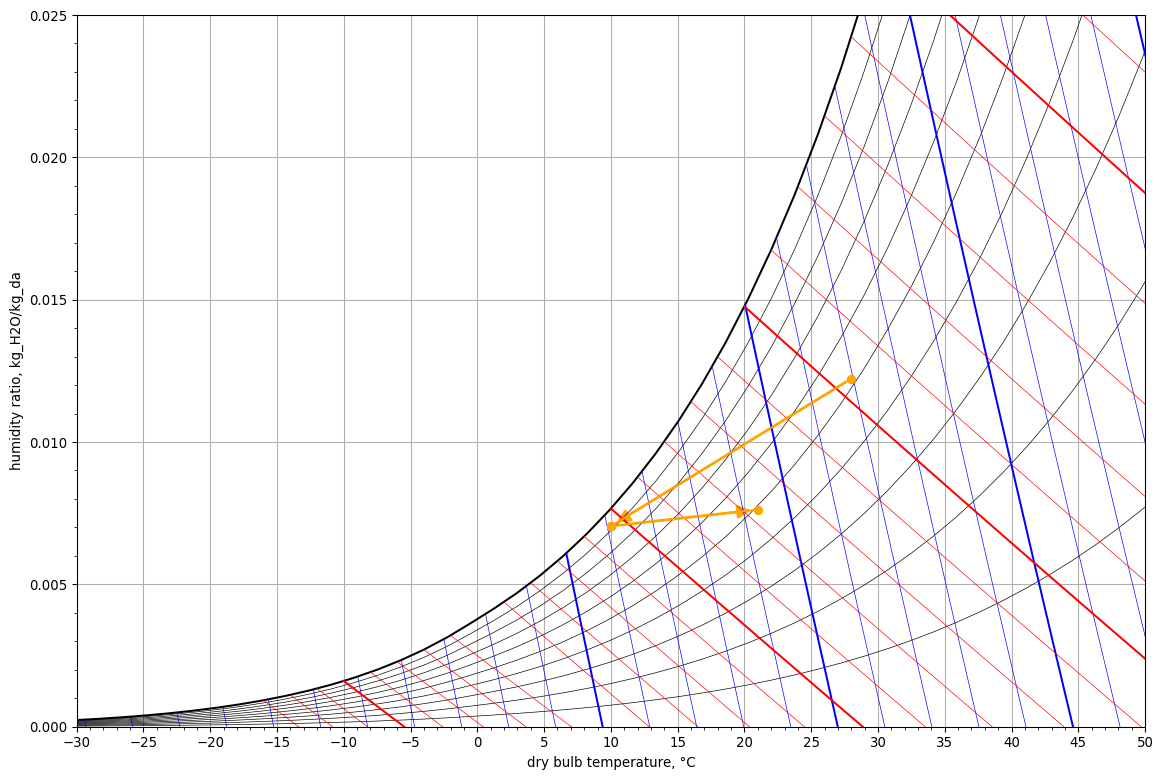

In [49]:
psych_chart = PsychrometricChart()

psych_chart.plot_process(
    name='room',
    start_point=StatePoint(room_design.air_in.Tdb, room_design.air_in.W),
    end_point=StatePoint(room_design.air_out.Tdb, room_design.air_out.W)
)

psych_chart.plot_process(
    name='air cooler',
    start_point=StatePoint(cooler_design.air_in.Tdb, cooler_design.air_in.W),
    end_point=StatePoint(cooler_design.air_out.Tdb, cooler_design.air_out.W)
)

psych_chart.show()

### Part Load Conditions

*The sensible heat gain diminishes to 1.175 kW, but the latent heat gain remains unchanged. Calculate the required supply air temperature to the room.*

**Required room air inlet state**

In [50]:
room_part = AirConditioningProcess(
    Q_sen=Q_(1.175, 'kW'),
    air_out=room_design.air_out,
    m_da=m_da,
    Q_lat=Q_(0.31, 'kW'),
    h_w=Q_(0.0, 'J / kg')
)

ja.display_list([
    f"required dry-bulb temperature of room supply air = <b>{room_part.air_in.Tdb.to('degC'):~P.1f}</b>",
    f"relative humidity in the room = <b>{room_design.air_out.RH.to('pct'):~P.0f}</b>",
    f"required moisture content of room supply air = <b>{room_part.air_in.W.to('g / kg'):~P.3f}</b>"
])

Whereas under design load conditions the supply air temperature to the room is 10 °C dry-bulb, under part load conditions the supply air temperature to the room needs to be higher, while the moisture content must remain the same as the latent heat load of the room has not changed. That is, the cooler coil must exercise its full dehumidifying function, the state of the air leaving the coil being the same as under design load conditions. Hence, the Apparatus Dew Point of the air cooler must remain the same.

In [47]:
cooler_part = AirConditioningProcess(
    air_in=cooler_air_in,
    ADP=cooler_design.ADP,
    W_ao=room_part.air_in.W,
    m_da=m_da,
    h_w=Q_(0.0, 'J / kg')
)

ja.display_list([
    f"load on cooler coil at part load conditions = <b>{cooler_part.Q.to('kW'):~P.3f}</b>",
    f"moisture content of air at cooler exit = <b>{cooler_part.air_out.W.to('g/kg'):~P.3f}</b>",
    f"air temperature at cooler exit = <b>{cooler_part.air_out.Tdb.to('degC'):~P.1f}</b>"
])

**Reheater**

To reach the required supply air temperature to the room, its temperature has to be raised by a reheating coil (i.e. a sensible heating process).

In [48]:
reheater = AirConditioningProcess(
    air_in=cooler_part.air_out,
    air_out=room_part.air_in,
    m_da=m_da,
    m_w=Q_(0.0, 'kg / s'),
    h_w=Q_(0.0, 'J / kg')
)

ja.display_list([
    f"load on reheater = <b>{reheater.Q_sen.to('kW'):~P.3f}</b>",
    f"load on reheater = <b>{reheater.Q_lat.to('kW'):~P.3f}</b>"
])

We will plot the cooling process, the reheating process and the room process together on the psychrometric chart:

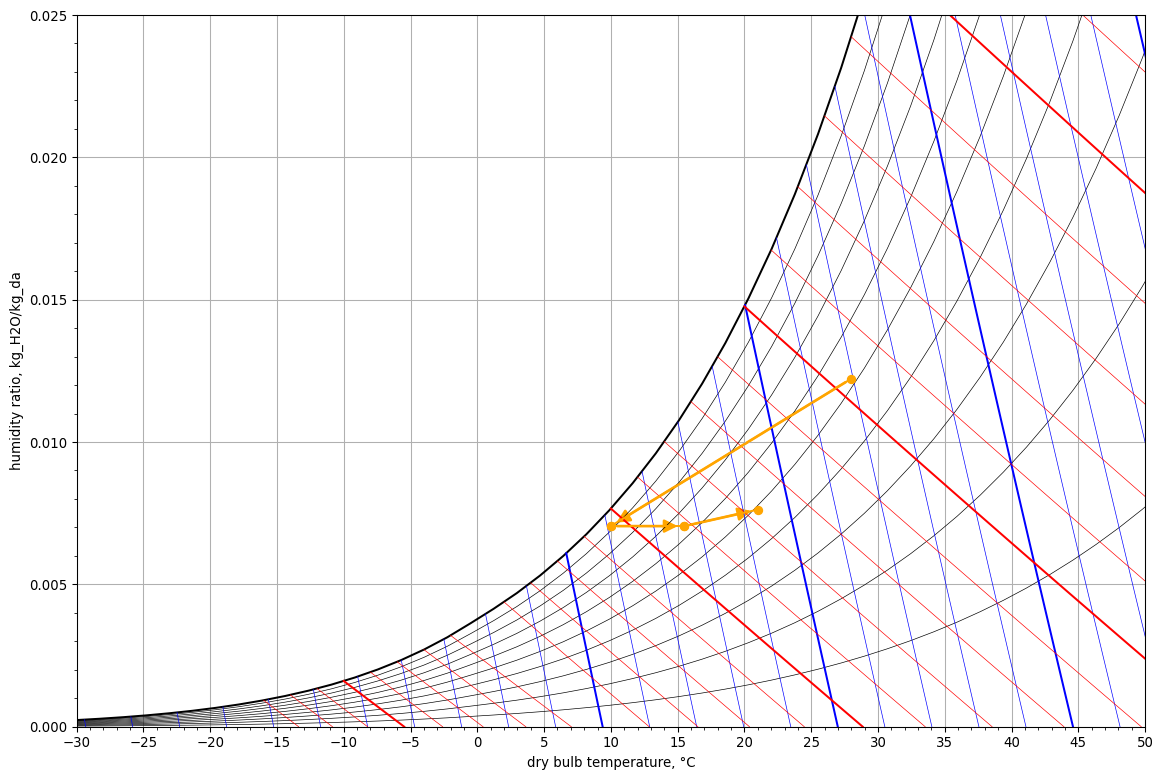

In [49]:
psych_chart = PsychrometricChart()

psych_chart.plot_process(
    name='room',
    start_point=StatePoint(room_part.air_in.Tdb, room_part.air_in.W),
    end_point=StatePoint(room_part.air_out.Tdb, room_part.air_out.W)
)

psych_chart.plot_process(
    name='air cooler',
    start_point=StatePoint(cooler_part.air_in.Tdb, cooler_part.air_in.W),
    end_point=StatePoint(cooler_part.air_out.Tdb, cooler_part.air_out.W)
)

psych_chart.plot_process(
    name='reheater',
    start_point=StatePoint(reheater.air_in.Tdb, reheater.air_in.W),
    end_point=StatePoint(reheater.air_out.Tdb, reheater.air_out.W)
)

psych_chart.show()